In [3]:
#This code is in addition to the files Retrievals.ipynb (download link in README), utils.py, and location_encoding_model_train.ipynb, in which we perform the experiments.
#Loading EEG data from DreamDiffusion
import os
import torch
eeg_file_path = "./DreamDiffusion/datasets/eeg_5_95_std.pth" #Data from https://github.com/perceivelab/eeg_visual_classification
eeg_dataset = torch.load(eeg_file_path)

from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from  datetime import  datetime, timedelta
import requests
from  io import BytesIO

In [18]:
eeg_data = eeg_dataset["dataset"] #Data associated to EEG
images =  eeg_dataset["images"] #Images 
labels = eeg_dataset["labels"] #user labels

In [19]:
eeg_data[0]["eeg"].shape #128 sample EEG data recorded for 0.5 seconds at 1Hz

torch.Size([128, 500])

In [68]:
#Initiating CLIP model to embed images
 
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

def clip_image_encode(file_path = None,image= None):
    assert(not (file_path is None and image is None))
    image = Image.open(file_path) if not file_path is None else image 
    inputs = processor(images = image, return_tensors = "pt")
    inputs = {"pixel_values": inputs["pixel_values"].to(device)}
    embed = clip_model.get_image_features(**inputs)
    return embed

def clip_image_encode_online(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    inputs = processor(images=image, return_tensors="pt")
    inputs = {"pixel_values": inputs["pixel_values"].to(device)}
    embed = clip_model.get_image_features(**inputs)
    return embed

def clip_text_encode(text):
    inputs = processor(text = text, return_tensors = "pt", padding = True)
    inputs = {k: v.to(device) for k,v in inputs.items()}
    embed = clip_model.get_text_features(**inputs)
    return embed

In [21]:
#for the perfect_embeddings_model, we initially create a dictionary mapping each tensor to its corresponding image
eeg_to_data = {dat["eeg"]: {'image': dat["image"], "label": dat["label"], "subject": dat["subject"]} for dat in eeg_data}

#Simulated Perfect EEG Encoder
def p_eeg_embed(eeg): #On an A100 GPU, replace this function with the approximate embedding from DreamDiffusion or NeuroImagen for results on unseen data
    img_idx = eeg_to_data[eeg]["image"]
    imagenet_idx = images[img_idx]
    folder = imagenet_idx.split("_")[0]

    imagenet_path = "./DreamDiffusion/datasets/imageNet_images/"
    file_path = f"{imagenet_path}/{folder}/{imagenet_idx}.JPEG" #May need to use os.path.join(imagenet_path, folder, file)
    print(file_path)
    embedding = clip_image_encode(file_path)
    return embedding #Shape = [1, 512]
    

**Adding User's Photos to a Pinecone Index**

In [9]:
#First initialize Google Photos API access
SCOPES = ['https://www.googleapis.com/auth/photoslibrary.readonly']
flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
creds = flow.run_local_server(port=8080)
google_photos = build('photoslibrary', 'v1', credentials=creds, static_discovery=False)

#Define necessary access functions


def fetch_photos_by_date(gp, start_date, end_date, max = 1000):
    body = {
        'filters': {
            'dateFilter': {
                'ranges': [
                    {
                        'startDate': {'year': start_date.year, 'month': start_date.month, 'day': start_date.day},
                        'endDate': {'year': end_date.year, 'month': end_date.month, 'day': end_date.day}
                    }
                ]
            }
        }
    }

    all_photos = []
    next_page_token = None

    while True and len(all_photos) < max:
        if next_page_token:
            body['pageToken'] = next_page_token

        results = gp.mediaItems().search(body=body).execute()
        all_photos.extend(results.get('mediaItems', []))

        next_page_token = results.get('nextPageToken')
        if not next_page_token:
            break

    return all_photos


def download_photo(photo_data, storage_path, cur_stored):
    if photo_data["id"] in cur_stored: 
        return
    if 'baseUrl' not in photo_data:
        print("Image Download Failed")
        return
    url = photo_data["baseUrl"] + "=d"
    res = requests.get(url)
    if res.status_code == 200:
        file_path = f"{storage_path}/{photo_data['id']}.jpg"
        with open(file_path, "wb") as f:
            f.write(res.content)
        cur_stored.add(photo_data["id"])

res = fetch_photos_by_date(google_photos, datetime.now() - timedelta(days=2920), datetime.now()) #fetch all photos in last 8 years
cur_stored = set()
storage_path = "./google_images/"
for photo in res: #this will then download all the photos, for 1000 photos takes around 10 minutes
    download_photo(photo, storage_path, cur_stored)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=119805090482-gi999vu35q3jesnci170494f3mbb98hb.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fphotoslibrary.readonly&state=G5OwWyzkrdd8VgYIfH6Et61l5lCwsw&access_type=offline


In [ ]:
#This will allow us to get relevant photos from a user's location 
Flickr_Key = ""
with open("Flickr_cred.txt", "r") as f:
    Flickr_Key = f.read()
    
base_url = "https://api.flickr.com/services/rest"

def photos_by_loc(lat, long, max=500):
    params = {
        'method': 'flickr.photos.search',
        'api_key': Flickr_Key,
        'format': 'json',
        'nojsoncallback': 1,
        'lat': lat,
        'lon': long,
        'per_page': max,
        'page': 1
    }
    res = requests.get(base_url, params)
    return res.json()

coords_list = [(40.7128, -74.0060)]  # (lat, long), This is an example for NYC
photo_list = []
for coords in coords_list:
    photos = photos_by_loc(coords[0], coords[1], 100)['photos']['photo']
    photo_list.extend(photos)

for photo_data in photo_list:
    url = f"https://farm{photo_data['farm']}.staticflickr.com/{photo_data['server']}/{photo_data['id']}_{photo_data['secret']}.jpg"
    res = requests.get(url)
    with open(f"{storage_path}/{photo_data['title']}.jpg", "wb") as f:
        f.write(res.content)

In [26]:
import pinecone
key = ""
with open("./pinecone_keys.txt", "r") as f:
    key = f.read()
pinecone.init(api_key = key, environment = "us-east-1-aws")


In [11]:
pinecone.create_index("userimages", dimension = 512, metric = "cosine")
user_index = pinecone.Index("userimages")

In [12]:
from datetime import datetime, timedelta
import random
import numpy as np

In [ ]:
#Choose as storage path from above, I will instead use ImageNet data
#This allows us to mass upload images, from a folder, to Pinecone with the necessary CLIP encoding
folder_to_read = "C:/Users/devan/Downloads/ILSVRC2015_DET_test/ILSVRC2015/Data/DET/test" #50,000 images

batch_size = 100 #Will upload in batches
files = os.listdir(folder_to_read)


for sect in range(0,len(files),100):
    upload_list = []
    files_subset = files[sect: sect+100]
    assert(len(upload_list) <= 100)
    for idx,file in enumerate(files_subset):
        file =  f"{folder_to_read}/{file}"
        encode = clip_image_encode(file)
        as_arr = encode[0].detach().cpu().numpy().tolist()
        

        #Adding artificial metadata
        rnd_date = datetime.now() - timedelta(random.random() * 3 * 365)
        lat, lon = np.random.normal(40.7218, 0.1), np.random.normal(-74.0060,0.1) #memories primarily occur around NYC
        metadata = {"lat":lat,
                    "lon":lon,
                    "date": rnd_date.strftime("%Y-%m-%d %H:%M")}
         
        upload_list.append((str(sect+idx), as_arr, metadata))
        
    # print(upload_list)
    user_index.upsert(upload_list)
    print(sect+100)

**Creating a Global Image Store**

In [18]:
pinecone.create_index("globalimages", dimension = 512, metric = "cosine")

In [13]:
global_index = pinecone.Index("globalimages")

In [ ]:
#We advise to run this code with multithreading, using ThreadPoolExecuter from concurrent.futures with max_threads = 50 led to the strongest results (~200k images/day)
#This stores data from COYO-700M and we use it for evaluation and converting from CLIP embedding to text
for offset in range(100, 700000000,  100):
    
    try:
        url = "https://datasets-server.huggingface.co/rows"
        params = {
            "dataset": "kakaobrain/coyo-700m",
            "config": "default",
            "split": "train",
            "offset": offset,
            "length": 100
        }
        response = requests.get(url, params = params)
        data = response.json()

        upload_list = []
        for img in data["rows"]:
            try:
                data_to_keep = {
                    "row_idx": img["row_idx"],
                    "url": img["row"]["url"],
                    "text": img["row"]["text"]
                }

                encode = clip_image_encode_online(data_to_keep["url"])
                as_arr = encode[0].detach().cpu().numpy().tolist()
                
                upload_list.append((str(img["row"]["id"]), as_arr, data_to_keep))
                # print("reached")
            except:
                pass            
        # print(len(upload_list))
        print(offset)
        global_index.upsert(upload_list)
    except:  #We encounter issues on approximately 30% of images
        pass


**Querying the Databases**

In [14]:
#This function queries a given index, such as the user index
def query(data, index, encoder, top_k, include_values = False, store = None, return_clip = False):
    vector = encoder(data)
    vector = vector[0].detach().cpu().numpy().tolist()
    
    res  = index.query(vector = vector,  top_k =  top_k,  include_values = include_values,  include_metadata=True)
    if store != None:
        store.append(res)
    if return_clip:
        return res, vector
    return res

query(eeg_data[0]["eeg"], user_index, p_eeg_embed, 3)

./DreamDiffusion/datasets/imageNet_images//n02951358/n02951358_31190.JPEG


{'matches': [{'id': '28080', 'score': 0.835983217, 'values': []},
             {'id': '10980', 'score': 0.833284795, 'values': []},
             {'id': '2564', 'score': 0.832451, 'values': []}],
 'namespace': ''}

**Recall and Reconstruction**

In [15]:
#If we are to perform diffusion, we can imbue the clip embedding with information from our user through the user database. We can imbue information from other times the user has seen/thought of this object
#Weight of original clip embedding comes first in the weight_dist array
#Although this has some use for recall, it is primarily used for diffusion and embeddings
def  reconstruction(eeg, embed_cnt= 3, weight_dist = None, include_thoughts = False):

    assert(weight_dist == None or len(weight_dist) == embed_cnt + 1)
    if weight_dist == None:
        weight_dist = [1/(embed_cnt+1)] * (embed_cnt+1)

    res,clip = query(eeg, user_index, p_eeg_embed, embed_cnt, True, return_clip = True)
    embeds = []
    for i in res["matches"]:
        embeds.append(i["values"])
    weighted_avg = [sum(weight_dist[idx] * arr[i] for (idx,arr) in enumerate([clip] + embeds)) for i in range(len(clip))]
    return weighted_avg


#Get the top result. Rather than having a diffusion layer, we can dramatically improve speed with minimal cost 
def recall(eeg, imbue = False):
    if not imbue:
        return query(eeg, global_index, p_eeg_embed, 1)
    vec = reconstruction(eeg)
    return global_index.query(vector = vec,  top_k =  1, include_metadata=True)

In [16]:

recall(eeg_data[3]["eeg"],  imbue = True) , recall(eeg_data[3]["eeg"]) #Compare before and after we imbue user experience, in this case no change in found image 

./DreamDiffusion/datasets/imageNet_images//n02951358/n02951358_34807.JPEG
./DreamDiffusion/datasets/imageNet_images//n02951358/n02951358_34807.JPEG


({'matches': [{'id': '4174708846952',
               'metadata': {'row_idx': 2014137.0,
                            'text': 'Kayaking the Middle Fork of the Salmon '
                                    'River, Kayak, Whitewater',
                            'url': 'https://www.idahowildernesscompany.com/wp-content/uploads/sites/15/2019/03/unnamed-3.jpg'},
               'score': 0.893892229,
               'values': []}],
  'namespace': ''},
 {'matches': [{'id': '4174708846952',
               'metadata': {'row_idx': 2014137.0,
                            'text': 'Kayaking the Middle Fork of the Salmon '
                                    'River, Kayak, Whitewater',
                            'url': 'https://www.idahowildernesscompany.com/wp-content/uploads/sites/15/2019/03/unnamed-3.jpg'},
               'score': 0.851317585,
               'values': []}],
  'namespace': ''})

**Establish Brain Embedding Database**

In [17]:
pinecone.create_index("brainindex", dimension = 512, metric = "cosine")
brain_index = pinecone.Index("brainindex")

In [ ]:
cur_time = datetime.now()
#Going to embed first 10000 images

brain_embed_store = []

upload_list = []
for i in range(10000): 
    try:
        vec = p_eeg_embed(eeg_data[i]["eeg"])
        as_arr = vec[0].detach().cpu().numpy().tolist()
        lat, lon = np.random.normal(40.7218, 0.1), np.random.normal(-74.0060,0.1) #memories primarily occur around NYC
        metadata = {"lat":lat,
                    "lon":lon,
                    "date": cur_time.strftime("%Y-%m-%d %H:%M"),
                    "notes": "Empty"}
        upload_list.append((str(i), as_arr, metadata))
        brain_embed_store.append(upload_list[-1])
        rnd_shift = max(np.random.normal(0.1,0.05),0)
        cur_time -= timedelta(rnd_shift)
    except Exception as err:
        print(err)
        pass
    if (len(upload_list) == 100):
        brain_index.upsert(upload_list)
        upload_list = []
brain_index.upsert(upload_list)
brain_embed_store.reverse()
# 9995 images successfully processed (data corruption issue with other 5)

**Summarize Thoughts Over time**

In [ ]:
import openai
#Dates hould be in the format "2023-11-28", searches for any time after and including start and before end
def find_time_window(start, end):
    start_date = datetime.strptime(start, "%Y-%m-%d")
    end_date = datetime.strptime(end, "%Y-%m-%d")

    region = []
    for idx,rec in  enumerate(brain_embed_store):
        rec_date = datetime.strptime(rec[2]['date'], "%Y-%m-%d %H:%M")
        if start_date <= rec_date  <= end_date:
            region.append(idx)
    #If this leads to any slowdown for your application, perform this as a binary search 
    return region[0],  region[-1]


start, end = find_time_window("2023-11-20","2023-11-28")

def summarize_in_window(brain_embed_store, start, end):
    desc = []
    for i in range(start, end+1):
        retr = recall(brain_embed_store[i][1])
        caption =  retr["matches"]["metadata"]["text"]
        desc.append(caption)
    
    
        # blip_torch = torch.Tensor(brain_embed_store[i][1])
        #Can additionally use blip-captioning for improved accuracy
        #However, let to RAM issues with local testing
    with open("openai_cred",  "r")  as  f:
        api_key = f.read()
    openai.api_key = api_key
    combined_desc  = " | ".join(desc)
    prompt = f"Summarize the following descriptions, which are seperated by a pipe: \n\n {combined_desc} \n\n Summary:"
    try: 
        response = openai.Completion.create(
            model  = "text-davinci-003", 
            prompt  = prompt,
            max_tokens = 150
        )

        return response.choice[0].text.strip()
    except Exception  as e:
        print(f"Error in Synthesizing Response: {e}")
        return None

# def thought_summary(start, end):
#     beg, fin = find_time_window(start,end)
#     brain_data = brain_embed_store[beg: fin+1]
#     results = []
#     caption_res = []
#     blip_res = []
#     for data in brain_data:
#         results.append(global_index.query(data[1], top_k = 1, include_metadata=True))
#         print(results[-1])
#         caption_res.append(results[-1]["matches"][0]["metadata"]["text"])
        
#         #Get captions via BLIP
#         url = results[-1]["matches"][0]["metadata"]["url"]
#         img = Image.open(requests.get(url, stream=True).raw)
#         blip_res.append(blip_caption(img))
        
    
#     return zip(caption_res, blip_res)


# thought_summary("2023-11-20","2023-11-28")
    



In [83]:
#BLIP Image Captioning model, can be used for improved image captioning and better thought summary

from transformers import BlipForConditionalGeneration, BlipModel

blip_model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-large")
blip_proc = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

def blip_caption(img):
    text = "An image of "
    inputs = blip_proc(img, text, return_tensors = "pt")
    out = blip_model.generate(**inputs)
    print(out)
    return (blip_proc.decode(out[0], skip_special_tokens = True))

def blip_caption_online(url):
    text = "An image of "
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    inputs = blip_proc(img, text, return_tensors = "pt")
    out = blip_model.generate(**inputs)
    print(out)
    return (blip_proc.decode(out[0], skip_special_tokens = True))



**Measure Thought Alignment**

In [60]:
#Shape should be [1,512], should be torch tensors
def cosin_sim(vec1, vec2):
    vec1_norm = vec1/torch.norm(vec1, dim  = 1)
    vec2_norm = vec2/torch.norm(vec2, dim = 1)
    res = torch.mm(vec1_norm, vec2_norm.transpose(0,1))
    return res

def thought_correl(start, end, topic, emotion = False):
    beg, fin = find_time_window(start,end)
    brain_data = brain_embed_store[beg: fin+1]
    text = f"image of {topic}" if not emotion else  f"{topic} image" #i.e. image of dolphin, sad image
    topic_embed = clip_text_encode(text) #Shape [1, 512]
    res = []
    for i in brain_data:
        res.append(cosin_sim(topic_embed, i))
    return res

# thought_summary("2023-11-20","2023-11-28")
embed = clip_text_encode("skiing") #Happy works reasonably well, Sad is just all memes
vec = embed[0].cpu().detach().numpy().tolist()
global_index.query(vec, top_k = 20, include_metadata = True, include_values = False)
# tens  = torch.Tensor(res["matches"][0]["values"]).unsqueeze(dim = 0).to(device)
# cosin_sim(embed, tens)

{'matches': [{'id': '8194797638058',
              'metadata': {'row_idx': 2622887.0,
                           'text': 'Friends on ski holiday in mountains',
                           'url': 'https://envato-shoebox-0.imgix.net/cb57/380f-2774-48f9-83c6-2148d594ca64/ski024.jpg?auto=compress%2Cformat&fit=max&mark=https%3A%2F%2Felements-assets.envato.com%2Fstatic%2Fwatermark2.png&markalign=center%2Cmiddle&markalpha=18&w=700&s=d54b1fd143f0fff4ed3997cf1d796c52'},
              'score': 0.304554641,
              'values': []},
             {'id': '7516193229879',
              'metadata': {'row_idx': 2312497.0,
                           'text': 'extrémní : SLOW MOTION CLOSE UP: '
                                   'Snowboarder jumping over the sun in '
                                   'snowpark on a beautiful sunny day in snowy '
                                   'ski resort',
                           'url': 'https://vidcdn.123rf.com/450nwm/helivideo/helivideo1808/helivideo180800229

**Uploading data for Zoo Tests**

In [150]:
pinecone.create_index("testindex2", dimension = 512, metric = "cosine")
test_index2 = pinecone.Index("testindex2")

In [151]:
arr = os.listdir("C:/Users/devan/Documents/pythonPractice/Training_Dataset/imageNet_images")[:16]

In [152]:
animals = ["dog", "cat","moth","horse", "monkey","elephant", "panda", "fish", "planes","brush","kayak","phone","cup","car","computer","watch"]
mapping = list(zip(arr,animals))
dic = {i:j for i,j in mapping}

In [153]:
#Gathering images to upload. The first 16 have associated photos we upload as well, the nexr 16 do not
root_direc = "C:/Users/devan/Documents/pythonPractice/Training_Dataset/imageNet_images"

cntr = 0

test_set = []
upload_set = []
for direc in os.listdir(root_direc):
    if direc in list(dic.keys())[:8]:
        test_batch = os.listdir(f"{root_direc}/{direc}")[:2]
        upload_batch = os.listdir(f"{root_direc}/{direc}")[2:]
        por = True
    elif direc in dic.keys():
        test_batch = os.listdir(f"{root_direc}/{direc}")[:2]
        upload_batch = []
        por = False
    else:
        continue
    for file in test_batch:
        clip_vec = clip_image_encode(f"{root_direc}/{direc}/{file}")
        test_set.append((clip_vec, dic[direc]))
    for file in upload_batch:
        clip_vec = clip_image_encode(f"{root_direc}/{direc}/{file}")  
        as_arr = clip_vec[0].cpu().detach().numpy().tolist()
        upload_set.append((str(cntr), as_arr, {"label": dic[direc]}))
        cntr+=1

In [157]:
test_index2.upsert(upload_set)

{'upserted_count': 384}

In [ ]:
# Preliminary failed testing for encoding time and location into a CLIP embedding
# import time
# alpha = 1
# beta = 2

# timeNorm = time.time()/500000000
# lat, lon = np.random.normal(40.7218, 0.1), np.random.normal(-74.0060,0.1)
# lat, lon = lat/20, lon/20
# timeNorm, lat, lon =  timeNorm * alpha,  lat * beta,  lon * beta
# addend = [timeNorm,lat, lon]

# vec_test  = test_set[0][0]
# vec_test2 = test_set[1][0]

# mod1 = torch.concat((vec_test[0].cpu(), torch.Tensor(addend)))

# timeNorm = time.time()/500000000
# lat, lon = np.random.normal(40.7218, 0.1), np.random.normal(-74.0060,0.1)
# lat, lon = lat/20, lon/20
# timeNorm, lat, lon =  timeNorm * alpha,  lat * beta,  lon * beta
# addend = [timeNorm,lat, lon]

# mod2 = torch.concat((vec_test2[0].cpu(), torch.Tensor(addend)))

# print(cosin_sim(mod1.unsqueeze(dim = 0), mod2.unsqueeze(dim = 0)))
# for (cat, upload_vec) in upload_set:
#     vec = upload_vec[1]
#     if (cat == "near"):
#         timeNorm = time.time()/500000000
#         lat, lon = np.random.normal(40.7218, 0.1), np.random.normal(-74.0060,0.1)
#         lat, lon = lat/20, lon/20
#         timeNorm, lat, lon =  timeNorm * alpha,  lat * beta,  lon * beta
#         addend = [timeNorm,lat, lon]
#     else:
#         timeNorm = time.time()/500000000
#         lat, lon = np.random.normal(50, 1), np.random.normal(-70,1)
#         lat, lon = lat/20, lon/20
#         timeNorm, lat, lon =  timeNorm * alpha,  lat * beta,  lon * beta
#         addend = [timeNorm,lat, lon]
#     print(addend)
        

In [82]:
#Use for noising
import numpy as np
def add_noise(arr, var):
    gn = np.random.normal(0, var, [512])
    np_res = gn + np.array(arr)
    return np_res.tolist()

**CLIP Alignment Test for DreamScapeST1 and DreamScapeST2**

In [181]:
#This is the results for no  system
import torch 

def cosin_sim(vec1, vec2):
    vec1_norm = vec1/torch.norm(vec1, dim  = 1)
    vec2_norm = vec2/torch.norm(vec2, dim = 1)
    res = torch.mm(vec1_norm, vec2_norm.transpose(0,1))
    return res

cosine_sim_help= []
cosine_sim_no=  []

for i in range(41):
    trial_1 = []
    trial_2 = []
    for trial in range(5):

        for (X,y) in test_set[:16]:
            vec = X[0].cpu().detach().numpy().tolist()
            vec1 = torch.Tensor(add_noise(vec, i/20)).unsqueeze(dim = 0)
            vec2 = clip_text_encode(f"An image of {y}").cpu()
            val = cosin_sim(vec1, vec2).item()
            trial_1.append(val)
        
        for (X,y) in test_set[16:]:
            vec = X[0].cpu().detach().numpy().tolist()
            vec1 = torch.Tensor(add_noise(vec, i/20)).unsqueeze(dim = 0)
            vec2 = clip_text_encode(f"An image of {y}").cpu()
            val = cosin_sim(vec1, vec2).item()
            trial_2.append(val)

    cosine_sim_help.append(sum(trial_1)/80)
    cosine_sim_no.append(sum(trial_2)/80)

In [182]:
#This is the results for DreamScapeST1
cosine_sim_help2= []
cosine_sim_no2=  []

for i in range(41):
    trial_1 = []
    trial_2 = []
    for trial in range(5):     
        for (X,y) in test_set[:16]:
            vec = X[0].cpu().detach().numpy().tolist()
            vec = add_noise(vec, i/20)
            
            res = test_index2.query(vec, top_k = 3, include_metadata = True, include_values = True)
            avg_list = []

            #The 0.6 is the value for alpha
            for itm in res["matches"]:
                if itm['score'] > 0.6:
                    avg_list.append(itm["values"])
            new_vec = [sum(1/(2*len(avg_list)+1) * arr[j] for arr in ([vec] + avg_list+avg_list)) for j in range(len(vec))]
            new_vec = torch.Tensor(new_vec).unsqueeze(dim = 0)
            vec2 = clip_text_encode(f"An image of {y}").cpu()
            val = cosin_sim(new_vec, vec2).item()
            trial_1.append(val)
        for (X,y) in test_set[16:]:
            vec = X[0].cpu().detach().numpy().tolist()
            vec = add_noise(vec, i/20)
            res = test_index2.query(vec, top_k = 3, include_metadata = True, include_values = True)
            avg_list = []
            for itm in res["matches"]:
                if itm['score'] > 0.6:
                    avg_list.append(itm["values"])
            new_vec = [sum(1/(2*len(avg_list)+1) * arr[j] for arr in ([vec] + avg_list+avg_list)) for j in range(len(vec))]
            new_vec = torch.Tensor(new_vec).unsqueeze(dim = 0)
            vec2 = clip_text_encode(f"An image of {y}").cpu()
            val = cosin_sim(new_vec, vec2).item()
            trial_2.append(val)
    cosine_sim_help2.append(sum(trial_1)/80)
    cosine_sim_no2.append(sum(trial_2)/80)

In [153]:
import torch 
#This is template code. Introduce any method of modification into the code to test the response
#The blip model was having cuda memory issues, so I did not automate checking to ensure the subject was the same
#I manually checked for various different variances and the same new_vec construction as the above cell
#This is used to collect the Table1 Data

def cosin_sim(vec1, vec2):
    vec1_norm = vec1/torch.norm(vec1, dim  = 1)
    vec2_norm = vec2/torch.norm(vec2, dim = 1)
    res = torch.mm(vec1_norm, vec2_norm.transpose(0,1))
    return res


for (X,y) in test_set[:16]:
    vec = X[0].cpu().detach().numpy().tolist()
    vec1 = add_noise(vec, 1)
    # vec2 = clip_text_encode(f"An imag?e of {y}").cpu()
    res = global_index.query(vec1,top_k = 1, include_metadata =True)
    print(y, res["matches"][0]["metadata"])

for (X,y) in test_set[16:]:
    vec = X[0].cpu().detach().numpy().tolist()
    vec1 =add_noise(vec, 1)
    res = global_index.query(vec1,top_k = 1, include_metadata =True)
    print(y, res["matches"][0]["metadata"])

    # print(vec1.shape,vec2.shape)
    # print(y,res["matches"][0]["metadata"])

dog {'row_idx': 2375599.0, 'text': 'training help for you and your dog - Training Help For You And Your Dog', 'url': 'https://i0.wp.com/familypetshop.net/wp-content/uploads/2020/02/training_help_for_you_and_your_dog.jpg?w=640&ssl=1'}
dog {'row_idx': 2371876.0, 'text': 'a new doc among us by Julie Camburn', 'url': 'https://libvetclinic.com/wp-content/uploads/2015/06/a-new-doc-among-us-by-Julie-Camburn.jpg'}
cat {'row_idx': 2370132.0, 'text': 'Two at the watering hole', 'url': 'https://lh4.googleusercontent.com/proxy/1bTgpc7o454jdJmdQC6jDf3KB6BkAL0PWvgnYB0Frgk_GGldwN9wAXVfDmDJ5Nyh49PrCsWV4KCxsIB_53LSI8F86-mltD5Z8e1vQonp8UwJ=s0-d'}
cat {'row_idx': 2057480.0, 'text': 'Pets of Galway', 'url': 'https://www.eaglesmediacenter.com/wp-content/uploads/2017/01/IMG_0255-475x356.jpg'}
moth {'row_idx': 2682626.0, 'text': '(Sphragista - CCDB-29457-A05) @15 [ ] CreativeCommons - Attribution Non-Commercial Share-Alike (2017) CBG Photography Group Centre for Biodiversity Genomics', 'url': 'http://v3.bold

In [183]:
#This tests the clip alignment of our algorithm

print(cosine_sim_help)
print(cosine_sim_no)

print(cosine_sim_help2)
print(cosine_sim_no2)

#Change for Zoo relevant visualizations, Change for non-zoo related visualizations
print(sum(cosine_sim_help2)/sum(cosine_sim_help))
print(sum(cosine_sim_no2)/sum(cosine_sim_no))

[0.28544373996555805, 0.28347327299416064, 0.2802850591018796, 0.2689908564090729, 0.26187191884964706, 0.25054389610886574, 0.24108139388263225, 0.22595024034380912, 0.2138738801702857, 0.2078196857124567, 0.19200412780046464, 0.17861972199752926, 0.17942005954682827, 0.1599093025550246, 0.15084587559103965, 0.14735859604552387, 0.13483829367905856, 0.13467944231815637, 0.1291014001239091, 0.12692896234802903, 0.12040657963370904, 0.11125733811641111, 0.10844057495705783, 0.10497581944218837, 0.09421794804511592, 0.09372617830522359, 0.09705726851243526, 0.08943480436573736, 0.089642679260578, 0.0786936791948392, 0.07855946717318148, 0.0708574077434605, 0.08069015140572447, 0.07094570975896204, 0.07569575840898324, 0.07382041776436381, 0.07381517018002341, 0.06837547935865587, 0.06421825061261188, 0.0732149678398855, 0.05855534246948082]
[0.27806487306952477, 0.27592771165072916, 0.2718341998755932, 0.26613615918904543, 0.2527601685374975, 0.2434869844466448, 0.23226077035069465, 0.22

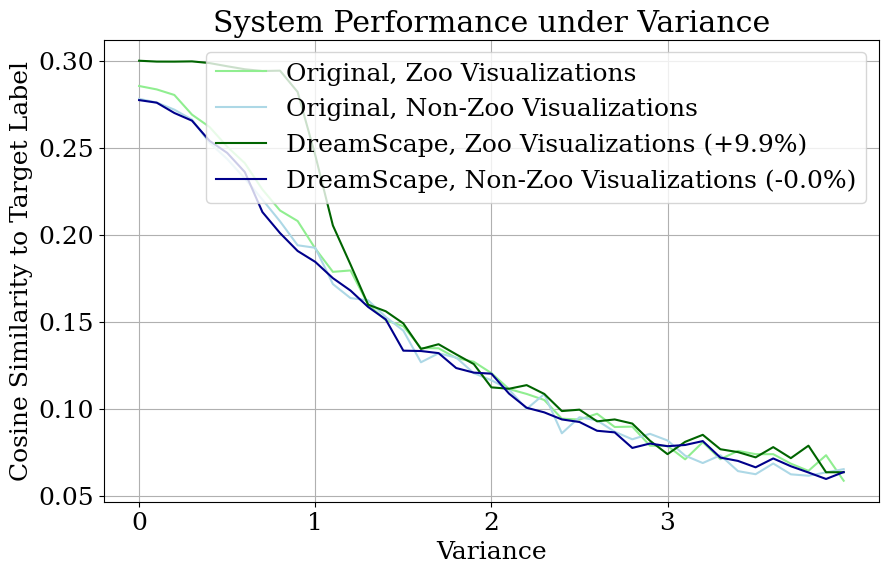

In [206]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 18
x_labels = [i/10 for i in range(41)]
plt.figure(figsize = (10,6))
plt.plot(x_labels, cosine_sim_help, label = "Original, Zoo Visualizations", color = "lightgreen")
plt.plot(x_labels, cosine_sim_no, label = "Original, Non-Zoo Visualizations", color = "lightblue")
plt.plot(x_labels, cosine_sim_help2, label = "DreamScape, Zoo Visualizations (+9.9%)", color = "darkgreen")
plt.plot(x_labels, cosine_sim_no2, label = "DreamScape, Non-Zoo Visualizations (-0.0%)",color =  "darkblue")
plt.xlabel('Variance')
plt.ylabel('Cosine Similarity to Target Label')
plt.title('System Performance under Variance')
plt.legend()
plt.grid(True)
plt.xticks([0, 1, 2, 3])
plt.show()

**Testing Temporal Encoding Model, tests for DreamScapeST2**

In [30]:
user_index = pinecone.Index("userimages")

In [108]:
#Reincoding cosine embeddings.  Going to have some relevant photos and many not  relevant photos

res = user_index.query([0]*512, top_k = 2995, include_values= True, include_metadata=True)
val_indx = []
# print(res["matches"])
for i in res["matches"]:
    val_indx.append((i["id"],i["values"]))
#Reaching internal server error if top_k >  3000


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.fc1 = nn.Linear(514, 512)  # 512 for vector + 2 for latitude and longitude
        self.fc2 = nn.Linear(512, 512)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = EmbeddingModel()

#Model is trained so that $cosine(f(v), f(v')) ~ cosine(v,v') + 1/e^(d lat + d long)
#Training Code in separate file
model.load_state_dict(torch.load("./st_embed_model"))




<All keys matched successfully>

In [208]:
import numpy as np
new_val_idx = []
for val in val_indx:
    vec = torch.Tensor(val[1])
    lat, lon = np.random.normal(43, .2), np.random.normal(-72,.2)
    ll = torch.tensor([lat, lon],  dtype = torch.float32)
    input = torch.cat((vec, ll))
    output = model(input)
    new_val_idx.append((val[0], output, {"clip_vec": val[1]}))


In [205]:
pinecone.create_index("testindex", dimension = 512, metric = "cosine")
test_index = pinecone.Index("testindex")

In [209]:
upload_list = []
for pair in new_val_idx:
    pair_id = pair[0]
    pair_vec = pair[1]
    upload_list.append((pair_id, pair_list, {"clip_vec": vec_str_list}))
    if pair == new_val_idx[0]:
        print(pair[2])
# print(upload_list[:10])
# test_index.upsert(upload_list[:100])
for i in range(30):
    test_index.upsert(upload_list[i * 100:(i+1)* 100+1])
# test_index.upsert(upload_list[:1000])
# test_index.upsert(upload_list[1001:2000])
# test_index.upsert(upload_list[2001:3000])

{'clip_vec': [-0.398487359, 0.107725307, 0.0629376918, 0.465926528, 0.403906882, 0.081071, -0.0449583977, 0.105451703, 0.158320218, 0.0812995657, 0.026642479, -0.177414134, 0.29683435, -0.169590563, 0.0698513389, -0.464185178, -0.160305947, 0.199761271, 0.161258161, -0.0444411561, 0.520820558, 0.000211469829, 0.191104338, 0.127264977, 0.346360385, 0.491429418, 0.28026554, -0.162965477, -0.302675664, 0.116651237, -0.510462821, 0.50600481, -0.200989813, 0.205978617, 0.359008, -0.3825863, -0.409547061, -0.696636677, -0.084923, 0.463305354, 0.140437, -0.251898825, 0.0566035, -0.200017557, 0.17637299, -0.290902615, -0.204386413, -0.0636715144, -0.452463359, 0.183658212, 0.0433678031, -0.470266223, 0.176304191, 0.264162898, -0.363403887, 0.373148084, -0.327572942, -0.290518165, 0.271239549, 0.147390887, -1.0498817, -0.20227775, 0.265948296, 0.212409094, 0.298699, 0.259678185, 0.118551835, 0.420382112, -0.436543286, 0.0713166893, -0.0940611213, 0.143261224, -0.316600919, -0.345267415, -0.4091

In [ ]:
root_direc = "C:/Users/devan/Documents/pythonPractice/Training_Dataset/imageNet_images"

cntr = 0

#Spacio-Temporal Encoding
#Partition Test set into Near and Far set

test_set = []
upload_set = []
for direc in os.listdir(root_direc):
    if direc in list(dic.keys())[:8]:
        test_batch = os.listdir(f"{root_direc}/{direc}")[:2]
        upload_batch = os.listdir(f"{root_direc}/{direc}")[2:]
        por = True
    elif direc in dic.keys():
        test_batch = os.listdir(f"{root_direc}/{direc}")[:2]
        upload_batch = []
        por = False
    else:
        continue
    for file in test_batch:
        clip_vec = clip_image_encode(f"{root_direc}/{direc}/{file}").cpu().squeeze(0)
        lat, lon = np.random.normal(40.7218, .1), np.random.normal(-74,.1)
        ll = torch.tensor([lat, lon],  dtype = torch.float32).cpu()
        print(clip_vec.shape, ll.shape)
        input = torch.cat((clip_vec, ll))
        output = model(input)
        test_set.append((output, clip_vec, dic[direc]))
    for file in upload_batch:
        clip_vec = clip_image_encode(f"{root_direc}/{direc}/{file}").cpu().squeeze(0)
        lat, lon = np.random.normal(40.7218, .1), np.random.normal(-74,.1)
        ll = torch.tensor([lat, lon],  dtype = torch.float32).cpu()
        input = torch.cat((clip_vec, ll))
        output = model(input)
        as_arr = output.cpu().detach().numpy().tolist()
        str_clip_vec = clip_vec.cpu().detach().numpy().tolist()
        str_clip_vec = list(map(str, str_clip_vec))
        upload_set.append((str(cntr), as_arr, {"label": dic[direc], "clip_vec": str_clip_vec}))
        cntr+=1
#upload to test_index

In [207]:
for i in range(0,int(len(upload_set)/100)+1):
    test_index.upsert(upload_set[i * 100:(i+1)* 100+1])
# test_index.upsert(upload_set)


In [215]:
import torch 

def cosin_sim(vec1, vec2):
    vec1_norm = vec1/torch.norm(vec1, dim  = 1)
    vec2_norm = vec2/torch.norm(vec2, dim = 1)
    res = torch.mm(vec1_norm, vec2_norm.transpose(0,1))
    return res

avg_cosine_sim_help= []
avg_cosine_sim_no=  []

for i in range(41):
    trial_1 = []
    trial_2 = []
    for trial in range(5):

        for (X,x, y) in test_set[:16]:
            # print(x.shape)
            vec = x.cpu().detach().numpy().tolist()
            vec1 = torch.Tensor(add_noise(vec, i/20)).unsqueeze(dim = 0)
            vec2 = clip_text_encode(f"An image of {y}").cpu()
            val = cosin_sim(vec1, vec2).item()
            trial_1.append(val)
        
        for (X,x,y) in test_set[16:]:
            vec = x.cpu().detach().numpy().tolist()
            vec1 = torch.Tensor(add_noise(vec, i/20)).unsqueeze(dim = 0)
            vec2 = clip_text_encode(f"An image of {y}").cpu()
            val = cosin_sim(vec1, vec2).item()
            trial_2.append(val)

    avg_cosine_sim_help.append(sum(trial_1)/80)
    avg_cosine_sim_no.append(sum(trial_2)/80)

    # print(vec1.shape,vec2.shape)
    # print(y,res["matches"][0]["metadata"])

In [219]:
avg_cosine_sim_help2= []
avg_cosine_sim_no2=  []

for i in range(41):
    trial_1 = []
    trial_2 = []
    for trial in range(5):     
        for (X,x,y) in test_set[:16]:
            vec = x.cpu().detach().numpy().tolist()
            vec = add_noise(new_vec, i/20)[0]

            lat, lon = np.random.normal(40.7218, .1), np.random.normal(-74,.1)
            ll = torch.tensor([lat, lon],  dtype = torch.float32).cpu()
            input = torch.cat((torch.Tensor(vec), ll))
            output = model(input)
            vec_up = output.cpu().detach().numpy().tolist()
            
            res = test_index.query(vec_up, top_k = 3, include_metadata = True, include_values = True)
      
            avg_list = []
            for itm in res["matches"]:
                if itm['score'] > 0.6:
                    avg_list.append(list(map(float, itm["metadata"]["clip_vec"])))
            new_vec = [sum(1/(2*len(avg_list)+1) * arr[j] for arr in ([torch.Tensor(vec)]+avg_list+avg_list)) for j in range(len(vec))]
            
            new_vec = torch.Tensor(new_vec).unsqueeze(dim = 0)
            vec2 = clip_text_encode(f"An image of {y}").cpu()
            val = cosin_sim(new_vec, vec2).item()
            trial_1.append(val)
        for (X,x,y) in test_set[16:]:
            vec = x.cpu().detach().numpy().tolist()
            vec = add_noise(new_vec, i/20)[0]

            lat, lon = np.random.normal(40.7218, .1), np.random.normal(-74,.1)
            ll = torch.tensor([lat, lon],  dtype = torch.float32).cpu()
            input = torch.cat((torch.Tensor(vec), ll))
            output = model(input)
            vec_up = output.cpu().detach().numpy().tolist()
            
            res = test_index.query(vec_up, top_k = 3, include_metadata = True, include_values = True)
            avg_list = []
            for itm in res["matches"]:
                if itm['score'] > 0.6:
                    avg_list.append(list(map(float, itm["metadata"]["clip_vec"])))
            new_vec = [sum(1/(2*len(avg_list)+1) * arr[j] for arr in ([torch.Tensor(vec)]+avg_list+avg_list)) for j in range(len(vec))]
            
            new_vec = torch.Tensor(new_vec).unsqueeze(dim = 0)
            vec2 = clip_text_encode(f"An image of {y}").cpu()
            val = cosin_sim(new_vec, vec2).item()
            trial_2.append(val)
    avg_cosine_sim_help2.append(sum(trial_1)/80)
    avg_cosine_sim_no2.append(sum(trial_2)/80)

In [211]:
print(avg_cosine_sim_help)
print(avg_cosine_sim_no)

print(avg_cosine_sim_help2)
print(avg_cosine_sim_no2)


print(sum(avg_cosine_sim_help2)/sum(avg_cosine_sim_help))
print(sum(avg_cosine_sim_no2)/sum(avg_cosine_sim_no))

[0.28544373996555805, 0.2831590551882982, 0.2789939513429999, 0.2702885016798973, 0.2612160760909319, 0.2500814372673631, 0.24109855871647595, 0.22546146251261234, 0.2172167466953397, 0.20424370067194103]
[0.27806487306952477, 0.2762430304661393, 0.27204399202018975, 0.2649580789729953, 0.2541094604879618, 0.24216532837599516, 0.23587072566151618, 0.21486792601644994, 0.20334743410348893, 0.19224222982302308]
[0.23624573089182377, 0.23603910412639378, 0.23625025246292353, 0.23093157801777126, 0.23437434639781712, 0.2357835229486227, 0.23609442953020335, 0.23481142204254865, 0.2366130743175745, 0.2337709030136466]
[0.2270603347569704, 0.22697970904409887, 0.22659341879189016, 0.2227914746850729, 0.22376579847186803, 0.22396747451275587, 0.22552796434611083, 0.22516406923532487, 0.22454357501119376, 0.22435414399951698]
0.9339390382184555
0.9247445943230063


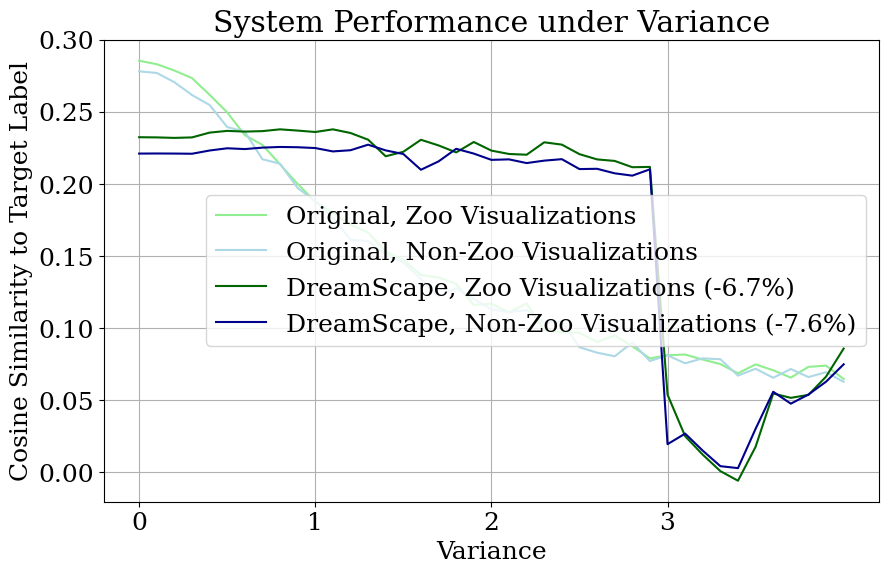

In [217]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 18
x_labels = [i/10 for i in range(41)]
plt.figure(figsize = (10,6))
plt.plot(x_labels, avg_cosine_sim_help, label = "Original, Zoo Visualizations", color = "lightgreen")
plt.plot(x_labels, avg_cosine_sim_no, label = "Original, Non-Zoo Visualizations", color = "lightblue")
plt.plot(x_labels, avg_cosine_sim_help2, label = "DreamScape, Zoo Visualizations (-6.7%)", color = "darkgreen")
plt.plot(x_labels, avg_cosine_sim_no2, label = "DreamScape, Non-Zoo Visualizations (-7.6%)",color =  "darkblue")
plt.xlabel('Variance')
plt.ylabel('Cosine Similarity to Target Label')
plt.title('System Performance under Variance')
plt.legend()
plt.grid(True)
plt.xticks([0, 1, 2, 3])
plt.show()

In [ ]:
#Code used to embed images in a file, used for uploading images for testing

path = "C:/Users/devan/Documents/pythonPractice/test_db"
import os, torch
for file in os.listdir(path):
    vec = clip_image_encode(file_path = f"{path}/{file}") 
    torch.save(vec, f"{path}/{file.split('.')[0]}_clip")

